# Homework Assignment 2  

## Question 1  

Using the Ohio lung cancer mortaility data build a model such that  

$Y_i | \beta_0, \delta_i \sim_{ind} Poisson(E_i e^{\beta_0} \delta_i)$  
$\delta_i | \alpha \sim_{iid} Gamma(\alpha, \alpha)$  

where $Y_i$ & $E_i$ are the observed and expected counts in county $i$ respectively  

### (a) Obtain the empirical Bayes estimates of $RR_i$ map them and plot them against the SMRs.  


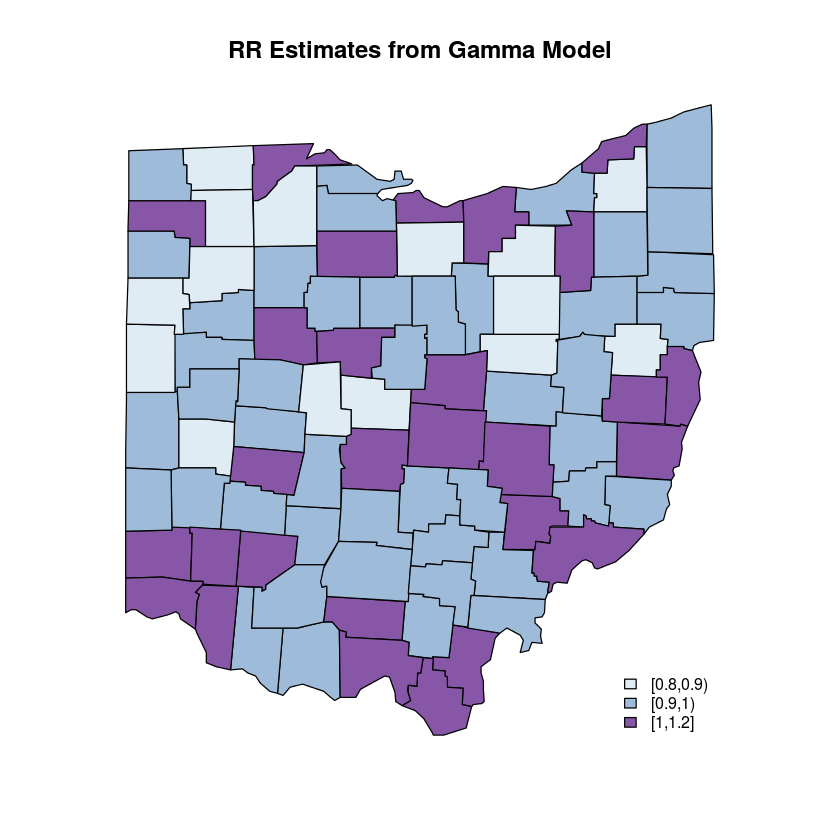

In [2]:
# load in the data set, hw1 Expected values counts, and some mapping functions 
options(jupyter.plot_mimetypes = 'image/png')
set.seed(123)
source("./hw2.R")

# get model estimates
eb_model <- eBayes(E=county$expected, Y=county$deaths)

# plot them
plot_ohio(eb_model$RR, title_="RR Estimates from Gamma Model", nclr=3)

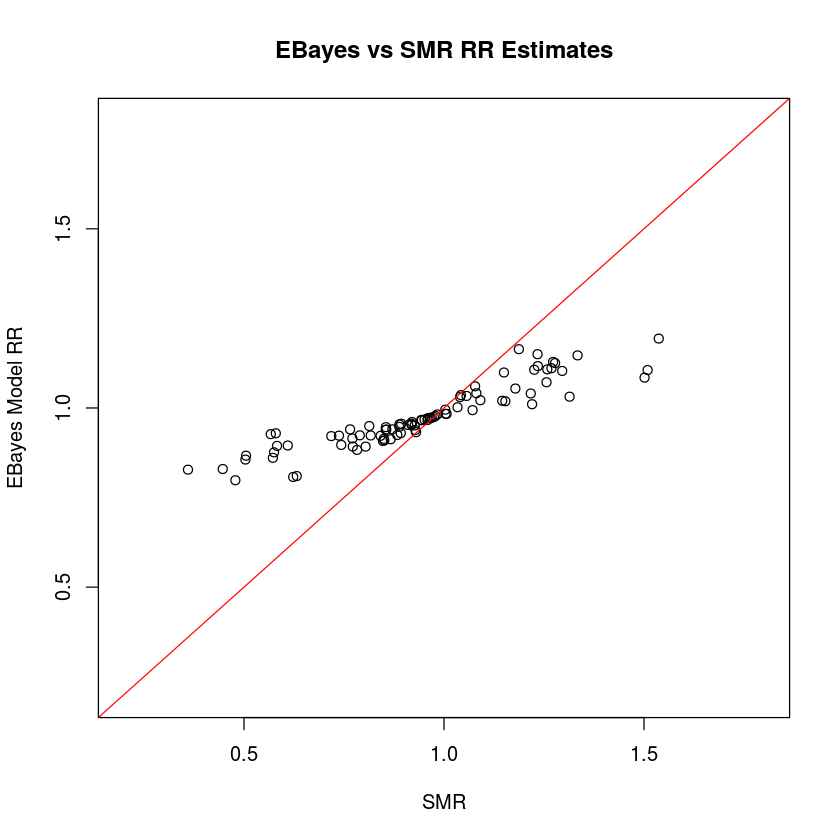

In [3]:
# plot the SMRs vs the Ebayes RR
plot(county$deaths / county$expected, eb_model$RR, ylab="EBayes Model RR", 
     xlab="SMR", main="EBayes vs SMR RR Estimates", ylim=c(.2, 1.8), xlim=c(.2, 1.8))
lines(c(0,2), c(0,2), col="red")

Looking at the plot of SMR vs EBayes RR results one can see that the gamma prior 
on the random effect $\delta$ pulls in the RR estimates such that their 
distribution is is more narrow. This moderates the extreme results however this 
model does not take into account any spatial relatedness of data points. 

### (b)Using $\beta$ & $\alpha$ provide histograms of RR for {1,2,3,4} by simulating the gamma distribution  

Given   
$RR_{i} ~ | ~ y_{i}, \hat{\beta}_{0}, \hat{\alpha}$  

The distribution of the results is

$$
Gamma \Big( \hat{\alpha} + y_i , 
            \frac{\hat{\alpha} + E_ie^{\hat{\beta_0}}}{e^{\hat{\beta_0}}} \Big)
$$

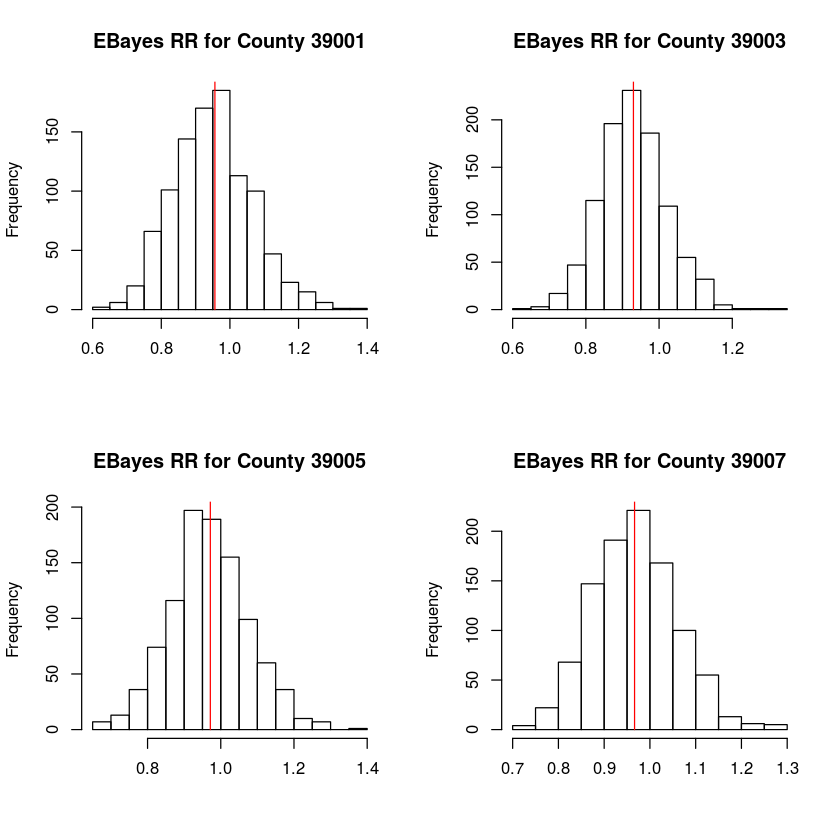

In [4]:
par(mfrow=c(2,2))
for (i in 1:4){
    # simulate the distribution given the parameters
    sim <- rgamma(1000, eb_model$alpha + county$deaths[i],
                  (eb_model$alpha + county$expected[i] * exp(eb_model$beta)) / exp(eb_model$beta))
    # plot with the posterior mean
    location <- county$fips[i]
    hist(sim, main=paste0("EBayes RR for County ", location), xlab="")
    lines(c(eb_model$RR[i],eb_model$RR[i]), c(0,400), col="red")
}

### (c) Plot the corresponding gamma densities using the `EBpostdens` function

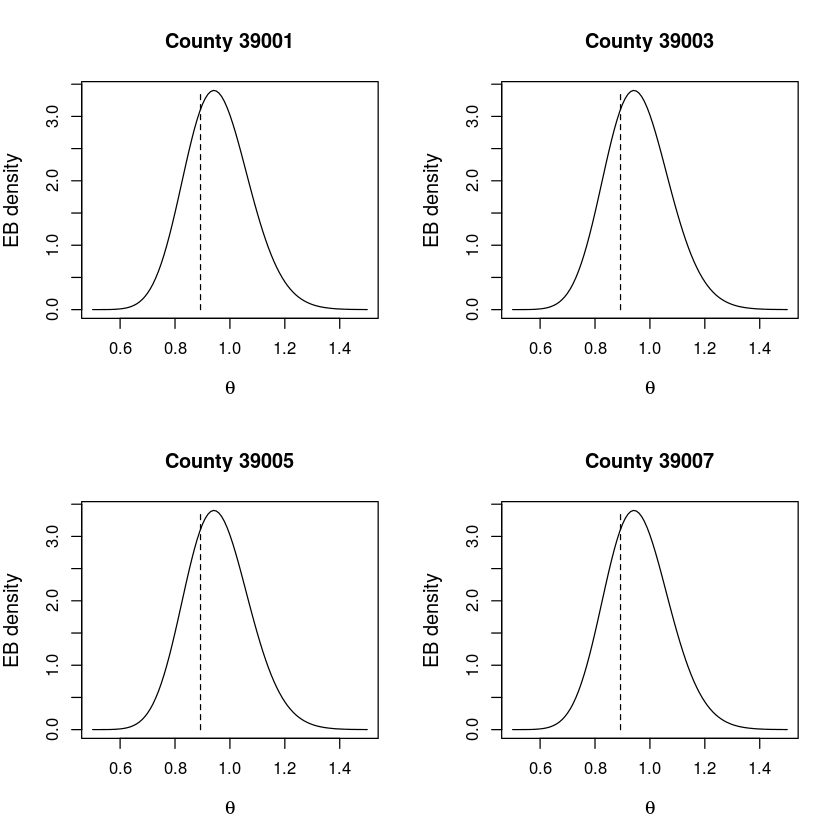

In [5]:
par(mfrow=c(2,2))
for (i in 1:4){
    location <- paste0("County ", county$fips[i])
    EBpostdens(county$deaths[1], county$expected[1], eb_model$alpha, 
               eb_model$beta, lower=0.5, upper=1.5, main = location)
}

### (d) Calculate the posterior medians, map them, & plot them againsnt the posterior means

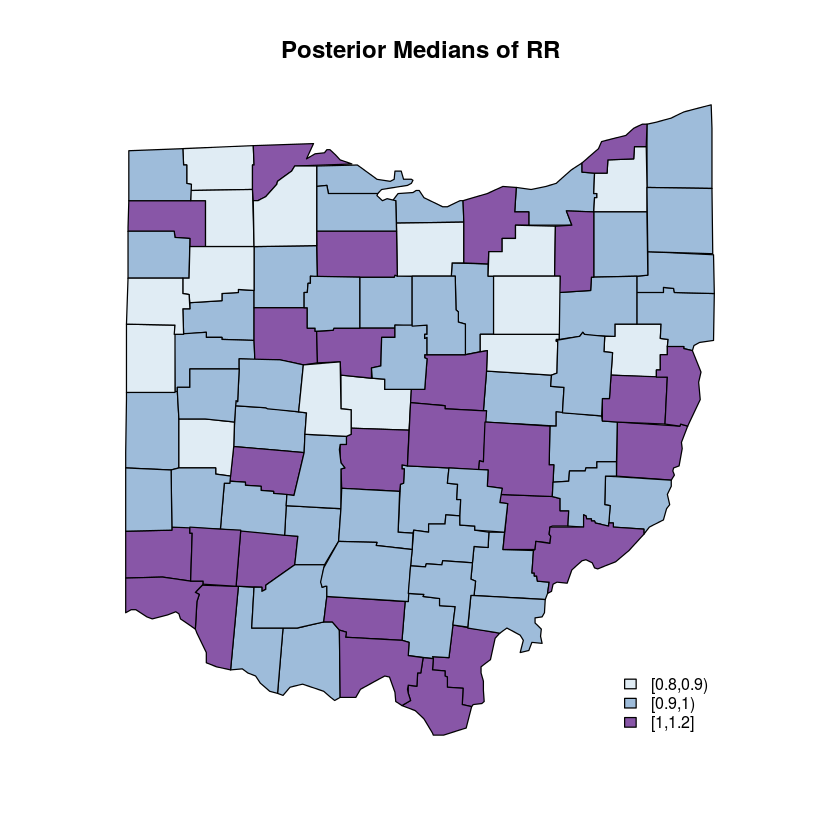

In [6]:
# use the qgamma function for the posterior median
county$post_med <- sapply(1:nrow(county), function(i) 
    qgamma(.5, eb_model$alpha + county$deaths[i],
           (eb_model$alpha + county$expected[i] * exp(eb_model$beta)) / exp(eb_model$beta)))
    
# map the results
par(mfrow=c(1,1))
plot_ohio(county$post_med, "Posterior Medians of RR", nclr=3)

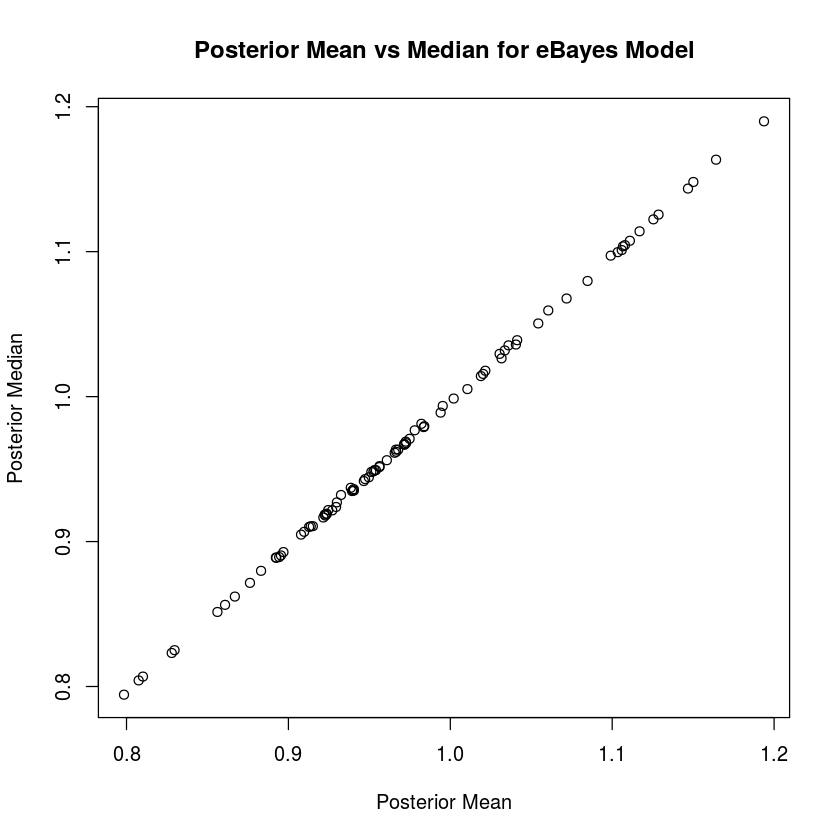

In [7]:
# plot the posterioir mean against the posterior meedian of RR
plot(eb_model$RR, county$post_med, xlab="Posterior Mean", ylab="Posterior Median", 
     main="Posterior Mean vs Median for eBayes Model")

In our results the posterior median and mean appear to be in a straight line. This 
should not come as a surprise as our model is fitted such that our RR are gamma 
distributed and gamma distributions approach normal when the shape parameter 
$k$ (or $\alpha + y_i$) is greater than $10$. In a normal distribution the mean and 
the median are equal. A calculation of all of our $k_i$ paramters show that the 
values are greater than 10 and thus approach normal. 

In [8]:
### all shape parameters are greater than 10
all(eb_model$alpha + county$deaths > 10)

[1] TRUE

### (e) Provide a map of the posterior SD's and compare with the SMR s.e. map  

Note that the SD of RR for the model is given by  
$$
sd(\hat{RR} ~ | ~ y_i,\hat{\alpha}, \hat{\beta_0} ) = 
\frac{e^{\hat{\beta_0}}(\hat{\alpha}+y_i)^{1/2}}{\hat{\alpha} + E_i e^{\hat{\beta_0}}}
$$

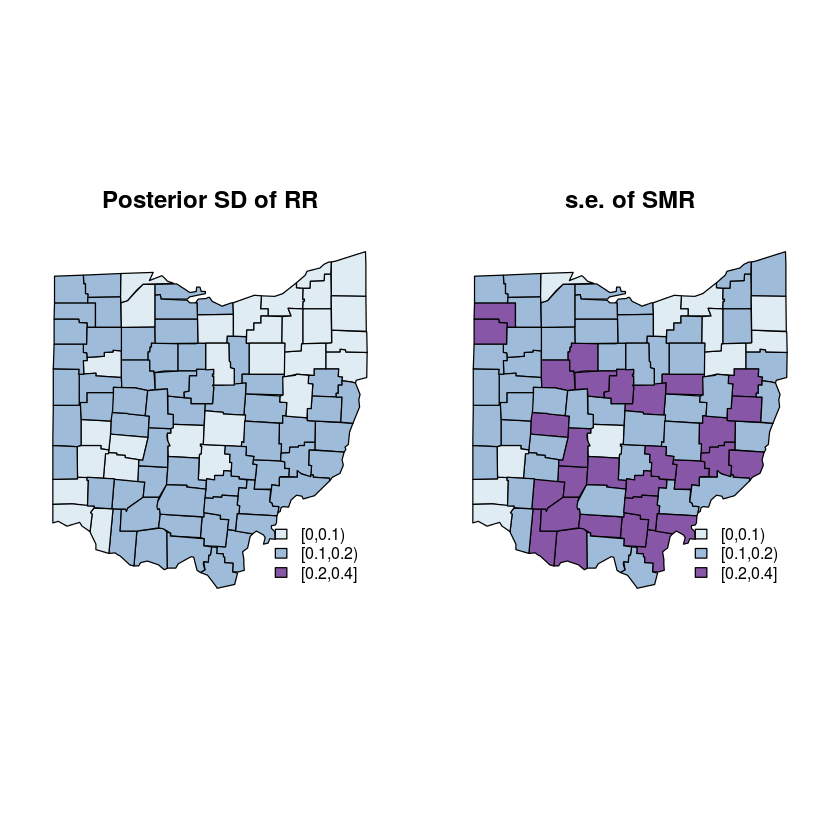

In [9]:
# calculate the posterior SD's

county$post_sd <- ((exp(eb_model$beta) * (eb_model$alpha + county$deaths)**.5)/
                   (eb_model$alpha + (county$expected * exp(eb_model$beta))))

par(mfrow=c(1,2))
plot_ohio(county$post_sd, title_="Posterior SD of RR", nclr=3, brks=c(0,.1,.2,.4))
plot_ohio(county$SMR_error, title_="s.e. of SMR", nclr=3)

Comparing SD of the posterior of RR to the s.e. of SMR we see that there is greater 
variability and greater values in the s.e. than the SD. This is to be suspected as 
the calculation of s.e. is much more susceptible to inflation as $Y_i$ increases 
when compared to the calculation of SD. This is seen below when we set the expected
numbers of deaths to 3 and increase our observed deaths number. 

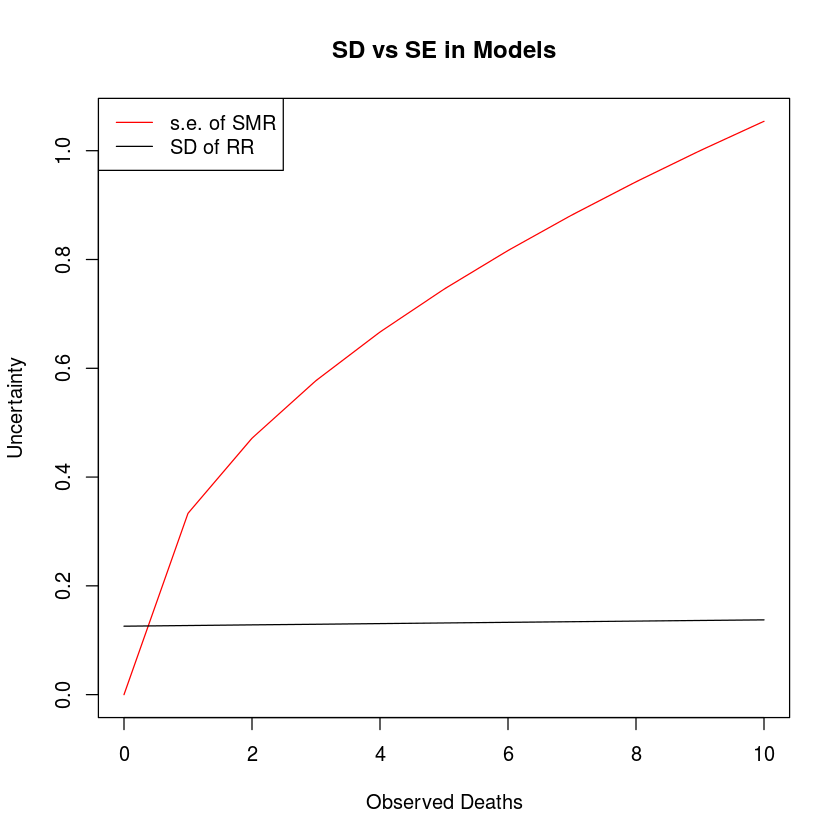

In [10]:
# watch how uncertainty increases for both models as deaths observed increases
# for a set number of expected 

# make quick functions for standard error and standard deviation
gen_sd <- function(Y, E, alpha, beta){
    ((exp(beta) * (alpha + Y)**.5)/ (alpha + (E + exp(beta))))
}

gen_se <- function(Y, E){
    (Y/E**2)**.5
}

fake_observed_values <- seq(from=0,to=10,by=1)

par(mfrow=c(1,1))

plot(fake_observed_values, gen_se(fake_observed_values, E=3), type="l", 
     ylab="Uncertainty", xlab="Observed Deaths", col="red",
     main="SD vs SE in Models")
lines(fake_observed_values, gen_sd(fake_observed_values, E=3, eb_model$alpha, eb_model$beta))
legend("topleft", c("s.e. of SMR", "SD of RR"), lty=c(1,1), col=c("red", "black"))

### (f) Calculate the posterior probability that $RR_i$ exceeds 1.2 & map it.   
Are their regions in which the RR appears significantly high?  

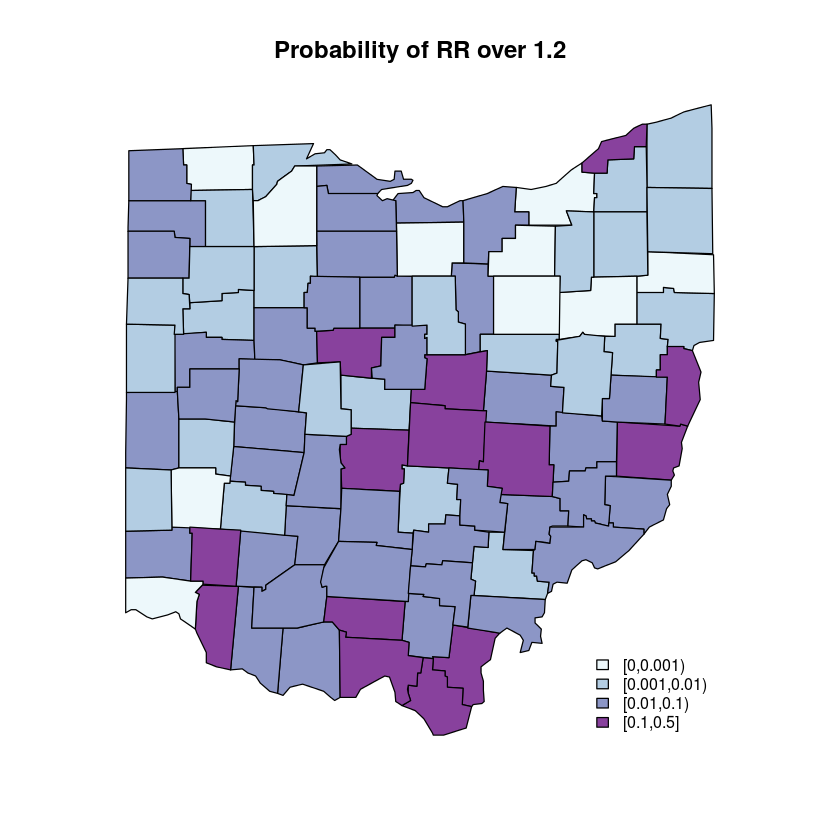

In [12]:
county$prob_over_threshold <- EBpostthresh(county$deaths, county$expected, alpha = eb_model$alpha, 
                                           beta = eb_model$beta, rrthresh = 1.2)

plot_ohio(county$prob_over_threshold, title_="Probability of RR over 1.2", nclr=4, brks=c(0, .001,.01,.1,.5))

There appear to be two clusters of Ohio counties where the relative risk seems 
higher than average. This may warrent some type of regional analysis to see what 
is driving up the relative risk in these clusters.  

### (g) Examine the proportionality assumption $p_{ij} = \delta_i \times q_j$ for some demographic  

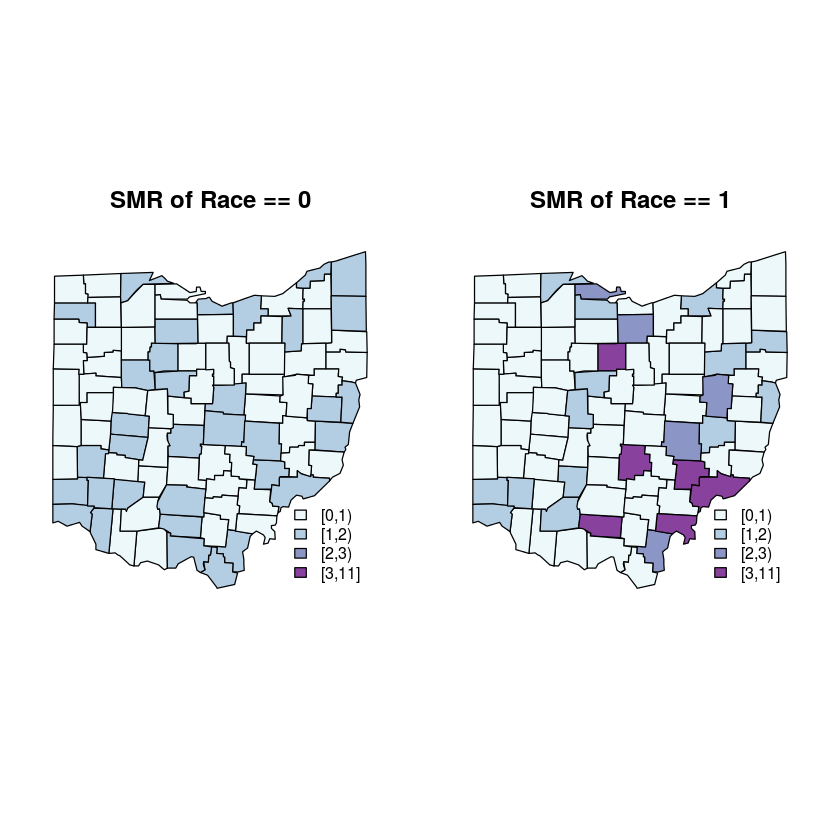

In [13]:
# make two new data sets for each race and calculate SMR
county0 <- ddply(subset(ohio, race==0), ~fips, summarise, expected=sum(expected), 
                deaths=sum(deaths))
county0 <- county0[order(county0$fips),]
county0$SMR <- county0$deaths / county0$expected

county1 <- ddply(subset(ohio, race==1), ~fips, summarise, expected=sum(expected), 
                deaths=sum(deaths))
county1 <- county1[order(county1$fips),]
county1$SMR <- county1$deaths / county1$expected

par(mfrow=c(1,2))
plot_ohio(county0$SMR, title_="SMR of Race == 0", nclr=4, brks=c(0,1,2,3,11))
plot_ohio(county1$SMR, title_="SMR of Race == 1", nclr=4, brks=c(0,1,2,3,11))

It appears that SMRs are not proportional across race for a given location $i$ and therefore may 
violate the assumption of proportionality.

## Question 2  
We will now be using the Poisson Log-normal model to estimate RR using the Ohio 
lung cancer data such that  

$Y_i | \beta_0, \delta_i \sim_{ind} Poisson(E_i e^{\beta_0} e^{\epsilon_i})$  
$\epsilon_i | \sigma^{2}_{\epsilon} \sim_{iid} \mathcal{N}(0, \sigma^{2}_{\epsilon})$  

where $Y_i$ & $E_i$ are the observed and expected counts in county $i$ respectively  

### (a) Fit this model with a default prior for $\alpha$ and a $Gamma(1,.026)$ prior for $\sigma^{-2}_{\epsilon}$  
Be sure to report the posterior medians and 95% intervals for $\beta_0$ and for $\sigma_{\epsilon}$  

In [14]:
# fit the model with prior on sigma
pln_model <- inla(deaths ~ 1 + f(fips, model = "iid", param = c(1, .026)),
                  data = county, family="poisson", E=county$expected)

In [13]:
# quantiles for beta
pln_model$summary.fixed[,3:5]

,0.025quant,0.5quant,0.975quant
(Intercept),-0.08460596,-0.03491985,0.0114201


In [14]:
# quantiles for sigma
pln_model$summary.hyperpar[,3:5]**-.5

,0.025quant,0.5quant,0.975quant
Precision for fips,0.1959957,0.1399694,0.0970146


### (b) Map the RR risk estimates from this model and compare them to the Gamma model

In [16]:
# We will use the median rather than the mean
county$lnormRR <- as.vector(exp(pln_model$summary.fixed[1,4]) * exp(pln_model$summary.random$fips[5]))[,1]

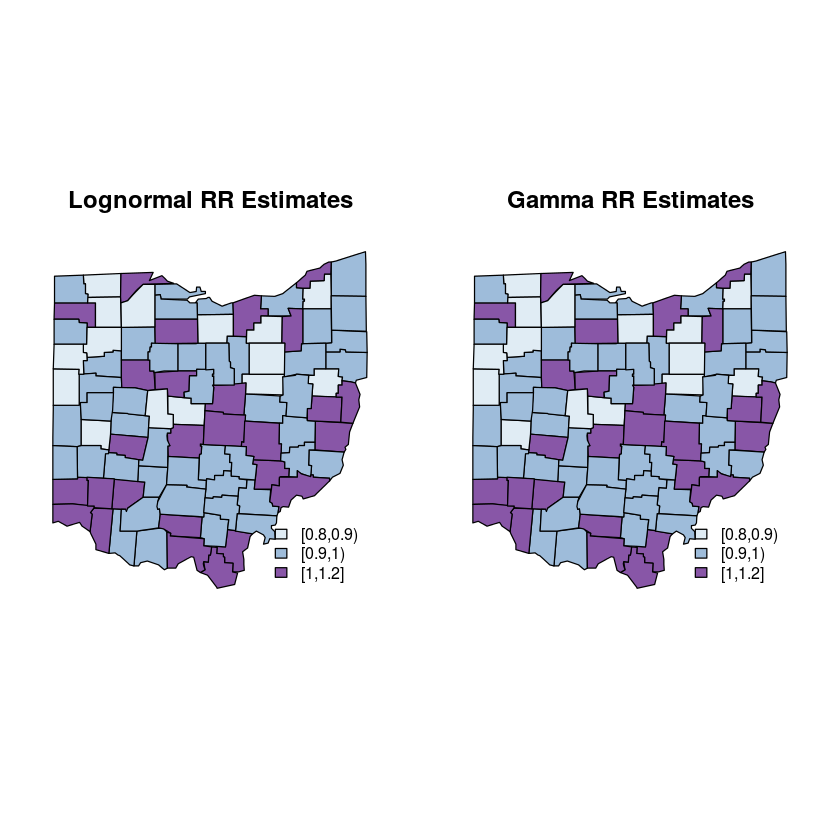

In [17]:
par(mfrow=c(1,2))
plot_ohio(county$lnormRR, title_="Lognormal RR Estimates", nclr=3)
plot_ohio(county$post_med, title_="Gamma RR Estimates", nclr=3)

The maps of these two models show that they give very similar results. 

### (c) Examine the assumption that the random effects follow $\mathcal{N}(0,\sigma^{2}_{\epsilon})$

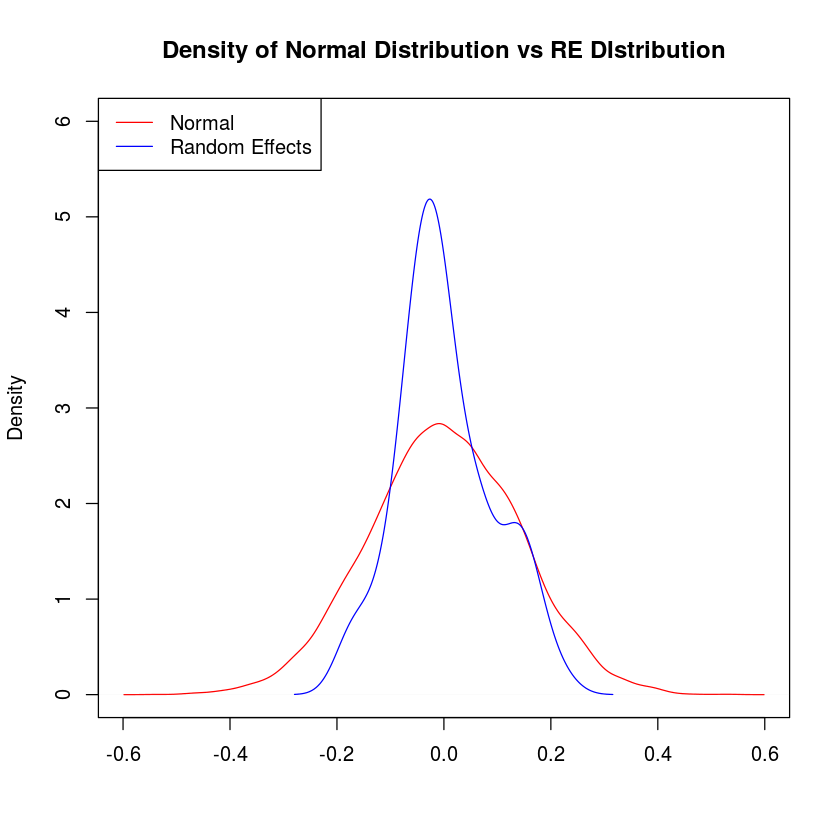

In [17]:
plot(density(rnorm(10000, 0, pln_model$summary.hyperpar[1,4]**-.5)), col="red", 
     ylim=c(0,6), xlab="", main="Density of Normal Distribution vs RE DIstribution")
lines(density(pln_model$summary.random$fips[,5]), col="blue")
legend("topleft", c("Normal", "Random Effects"), lty=c(1,1), col=c("red", "blue"))

Examing the density of the random effects it appears that the random effects have a tighter 
distribution around 0 than a $\mathcal{N}(0,\sigma^{2}_{\epsilon})$ would expect. 

## Question 3  
Investigate the properties of the empirical Bayes estimates. Specifically 
consider the mean squared error of the collection of estimates $\hat{\delta_i}$, 
compared to the true values of  $\delta_i$. Recall the mean squared error is  

$$
MSE(\hat{\delta_i}) = \frac{1}{n} \Sigma^{n}_{i=1}(\hat{\delta_i} - \delta_i)^2
$$

For $n = 50$, and $E_i ∼ Unif(0.1, 50)$ simulate  

$Y_i | \delta_i \sim Poisson(E_i \delta_i)$  

with  

$\delta_i \sim p_{\delta} (·)$  

and calculate the SMRs $Y_i / E_i$ and empirical Bayes estimates and 
hence the MSEs, for the choices of $\delta_i$.

a) $Gamma(5,5)$  
b) $Lognormal(0,1)$  
c) $Unif(0.1, 10)$  

In [18]:
# We have 50 observed values
N <- 50

# There expected values are uniformly distributed as mentioned above 
E <- runif(N, .1, 50)

# lets simulate all the random effects
deltas <- list(gamma=rgamma(N,5,5),
               lognormal=rlnorm(N,0, 1),
               uniform=runif(N, 0.1,10))

# now lets create 1000 instances observed deaths from these deltas
simulations <- lapply(deltas, function(d) sapply(1:1000, function(x)rpois(N, E * d)))

In [19]:
# Calculate the SMRs and get their "intercept"
SMR <- lapply(simulations, function(x) x / E) 
    
SMR_intercept <- lapply(simulations, function(x) colSums(x) / sum(E))

In [20]:
# Calculate the RR using Ebayes and pull the beta term
RR <- lapply(simulations, function(x) sapply(1:ncol(x), function(i)
    eBayes(x[,i], E)$RR))
    
RR_intercept <- lapply(simulations, function(x) sapply(1:ncol(x), function(i)
    exp(eBayes(x[,i], E)$beta[[1]])))

In [21]:
# Calculate delta for a model by taking RR estimate / intercept
SMR_delta_hat <- lapply(names(simulations), function(x) (simulations[[x]] / E) / SMR_intercept[[x]])
names(SMR_delta_hat) <- names(simulations)
RR_delta_hat <- lapply(names(simulations), function(x) (RR[[x]]) / RR_intercept[[x]])
names(RR_delta_hat) <- names(simulations)

In [22]:
# Calsulate the MSE for the values
SMR_MSE <- lapply(names(deltas), function(x) 
    colSums((SMR_delta_hat[[x]] - deltas[[x]])**2) / N)
names(SMR_MSE) <- names(deltas)
RR_MSE <- lapply(names(deltas), function(x) 
    colSums((RR_delta_hat[[x]] - deltas[[x]])**2) / N)
names(RR_MSE) <- names(deltas)

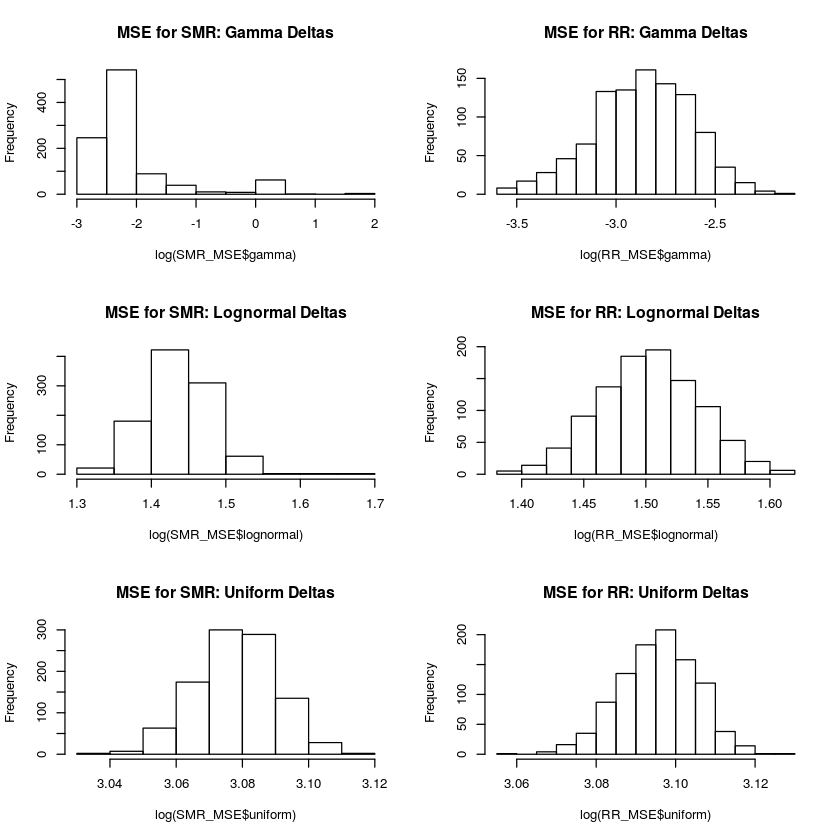

In [23]:
par(mfrow=c(3,2))

hist(log(SMR_MSE$gamma), main="MSE for SMR: Gamma Deltas")
hist(log(RR_MSE$gamma), main="MSE for RR: Gamma Deltas")
hist(log(SMR_MSE$lognormal), main="MSE for SMR: Lognormal Deltas")
hist(log(RR_MSE$lognormal), main="MSE for RR: Lognormal Deltas")
hist(log(SMR_MSE$uniform), main="MSE for SMR: Uniform Deltas")
hist(log(RR_MSE$uniform), main="MSE for RR: Uniform Deltas")

After running 1000 simulations it appears as if both models have very similar MSE for the uniform distribution of deltas however when there is structure to the deltas the gamma model outperforms the simple SMR estimate.

## Question 4  
Consider an alternative model where  

$Y_i | RR_i \sim_{ind} Poisson(E_i \times RR_i)$  

with  

$RR_i \sim_{ind} Gamma(\alpha^{\star} e^{\beta_0}, \alpha^{\star})$  
$E[RR_i | \beta_0, \alpha^{\star}] = e^{\beta_0}$  
$var(RR_i | \beta_0, \alpha^{\star}) = e^{\beta_0} / \alpha^{\star}$  

### (a) Find the posterior distribution of $RR_i$

In [18]:
# get are data and start values 
E <- county$expected # expected
Y <- county$deaths # observed
RR_start <- rep(1, length(Y)) # a starting point for RR values for each county

In [19]:
# build the likelihood prior and posterior
likelihood <- function(RR){
    sum(dpois(Y,E * RR, log=TRUE))
}

prior <- function(RR, alpha, beta){
    sum(dgamma(RR, alpha * exp(beta), alpha, log=TRUE))
}

posterior <- function(RR, alpha, beta){
   likelihood(RR) + prior(RR, alpha, beta)
}

In [20]:
# write out the MCMC algorithim
proposalfunction <- function(RR, alpha, beta){
    RR_new <- rnorm(length(RR), mean = RR, sd=c(0.05))
    alpha_new <- rnorm(1, mean=alpha, sd=.05)
    beta_new <- rnorm(1, mean=beta, sd=.05)
    list(RR=RR_new, alpha=alpha_new, beta=beta_new)
}

run_metropolis_MCMC <- function(RR_start, alpha_start, beta_start, iterations){
    chain <- array(dim = c(iterations+1,length(c(RR_start, alpha_start, beta_start))))
    chain[1,] <- c(RR_start, alpha_start, beta_start)
    RR_cols <- 1:length(RR_start)
    alpha_col <- ncol(chain) - 1
    beta_col <- ncol(chain)
    for (i in 1:iterations){
        proposal <- proposalfunction(chain[i,RR_cols], chain[i,alpha_col], chain[i,beta_col])
         
        probab <- exp(posterior(proposal$RR, proposal$alpha, proposal$beta) - 
                      posterior(chain[i,RR_cols], chain[i,alpha_col], chain[i,beta_col]))
        if (runif(1) < probab){
            chain[i+1,] <- c(proposal$RR, proposal$alpha, proposal$beta)
        }else{
            chain[i+1,] <- chain[i,]
        }
    }
    return(chain)
}

In [21]:
# Run the MCMC process
startvalue <- c(.5)
chain <- run_metropolis_MCMC(RR_start, 1, 1, 100000)
 
burnIn <- 5000
acceptance <- 1-mean(duplicated(chain[-(1:burnIn),]))

In [22]:
alpha_post <- chain[-(1:burnIn),ncol(chain) - 1]
beta_post <- chain[-(1:burnIn),ncol(chain)]
RR_post <- chain[-(1:burnIn),1:88]

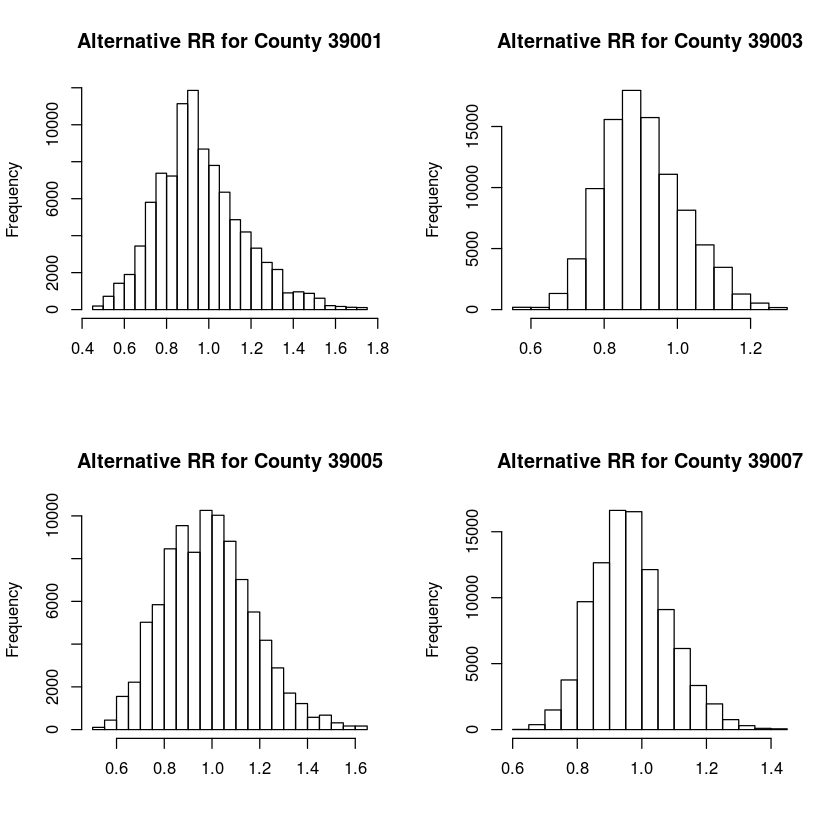

In [141]:
par(mfrow=c(2,2))
for (i in 1:4){
    location <- county$fips[i]
    hist(RR_post[,i], main=paste0("Alternative RR for County ", location), xlab="")
}

### (b) Evaluate the marginal mean and variance of the data under this model  

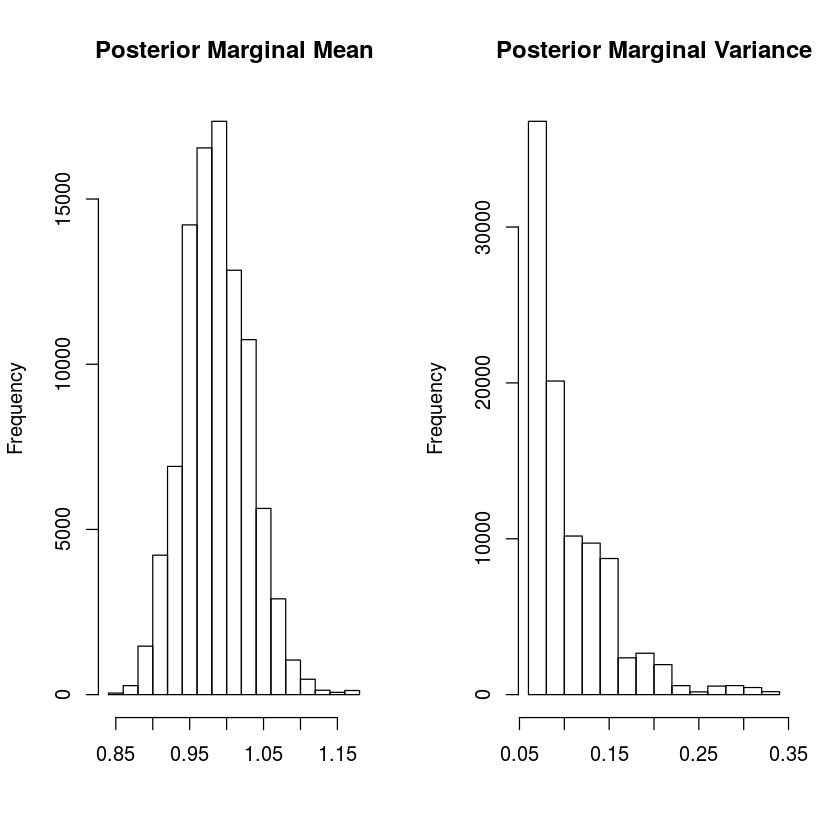

In [23]:
par(mfrow=c(1,2))
hist(exp(beta_post), xlab="", main="Posterior Marginal Mean")
hist(exp(beta_post)/alpha_post, xlab="", main="Posterior Marginal Variance")

### (c) Show that there is a difference between this model and the Ebayes model  
Furthermore, show that the estimates derived by the alternative model are  
$$
\hat{RR}_i = e^{\hat{\beta}_0} \times 
             \frac{\hat{\alpha}^{\star}}{\hat{\alpha}^{\star} + E_i} + 
             \frac{Y_i}{E_i} \times 
             \frac{E_i}{\hat{\alpha}^{\star} + E_i}
$$

In [117]:
RR_calc <- ((exp(mean(beta_post)) * (mean(alpha_post)/(mean(alpha_post) + E))) + 
            (Y/E) * (E/(mean(alpha_post) + E)))

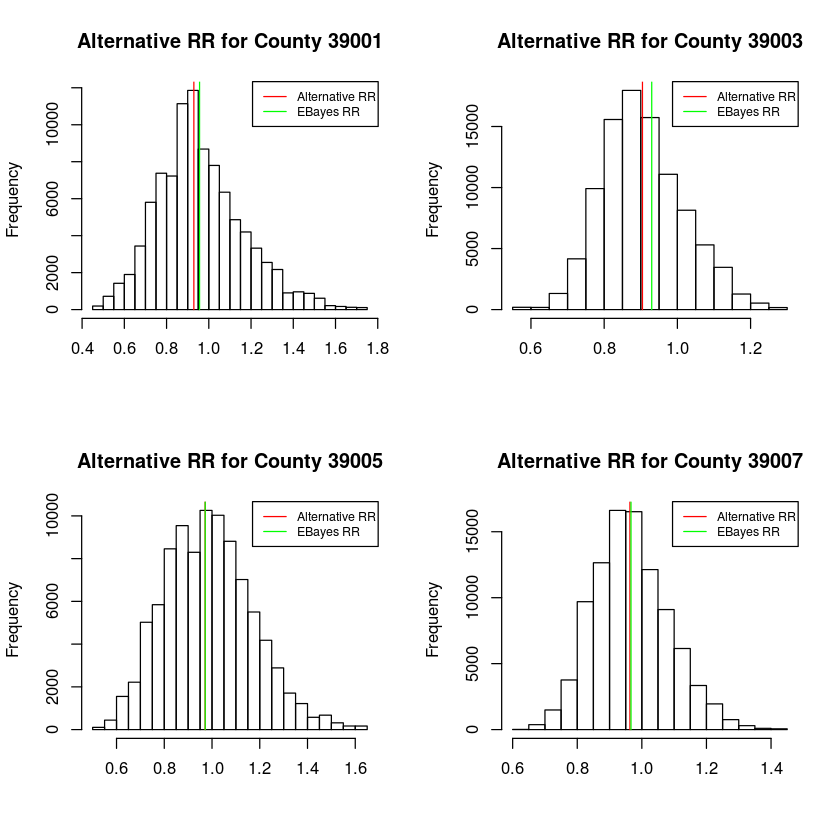

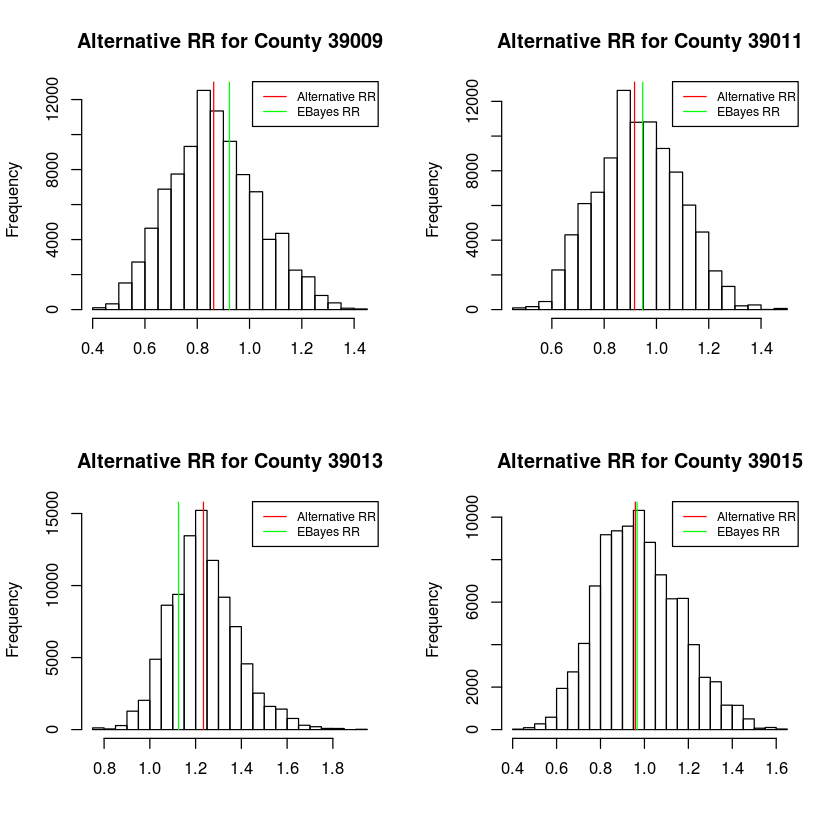

In [140]:
par(mfrow=c(2,2))
for (i in 1:8){
    location <- county$fips[i]
    hist(RR_post[,i], main=paste0("Alternative RR for County ", location), xlab="")
    lines(c(RR_calc[i], RR_calc[i]), c(0,1000000), col="red")
    lines(c(eb_model$RR[i], eb_model$RR[i]), c(0,1000000), col="green")
    legend("topright", legend=c("Alternative RR", "EBayes RR"), col=c("red", "green"),
          lty=1, cex=.75)
}

It appears that this model allows for a greater degree of dispersion of RR than the eBayes 
model however still less than an SMR estimate of RR would allow.